In [ ]:
# Install required libraries
!pip install ultralytics transformers open_clip_torch matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 913.6/913.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.8 MB/s eta 0:00:00


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Saving fruit_example.jpg to fruit_example.jpg


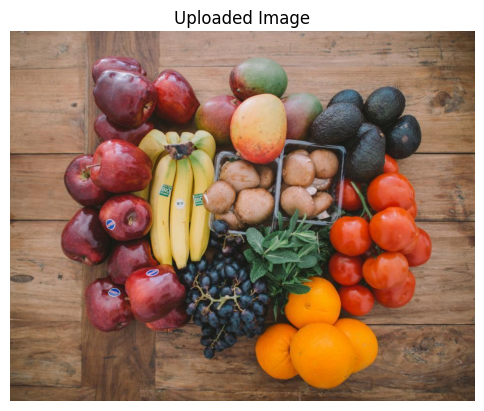

Enter the text prompt to identify objects: banana


100%|██████████| 5.35M/5.35M [00:00<00:00, 50.1MB/s]



image 1/1 /content/fruit_example.jpg: 512x640 1 banana, 6 apples, 5 oranges, 364.3ms
Speed: 15.7ms preprocess, 364.3ms inference, 24.4ms postprocess per image at shape (1, 3, 512, 640)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/open_clip/factory.py:380: UserWarning: These pretrained weights were trained with QuickGELU activation but the model config does not have that enabled. Consider using a model config with a "-quickgelu" suffix or enable with a flag.
  warnings.warn(


Debug Information for All Detected Objects:
Detected Object: banana
  YOLO Confidence: 0.84
  CLIP Similarity with Prompt ('banana'): 0.31
Detected Object: orange
  YOLO Confidence: 0.76
  CLIP Similarity with Prompt ('banana'): 0.23
Detected Object: orange
  YOLO Confidence: 0.61
  CLIP Similarity with Prompt ('banana'): 0.23
Detected Object: orange
  YOLO Confidence: 0.59
  CLIP Similarity with Prompt ('banana'): 0.24
Detected Object: orange
  YOLO Confidence: 0.37
  CLIP Similarity with Prompt ('banana'): 0.25
Detected Object: apple
  YOLO Confidence: 0.35
  CLIP Similarity with Prompt ('banana'): 0.21
Detected Object: apple
  YOLO Confidence: 0.34
  CLIP Similarity with Prompt ('banana'): 0.23
Detected Object: orange
  YOLO Confidence: 0.30
  CLIP Similarity with Prompt ('banana'): 0.24
Detected Object: apple
  YOLO Confidence: 0.30
  CLIP Similarity with Prompt ('banana'): 0.23
Detected Object: apple
  YOLO Confidence: 0.28
  CLIP Similarity with Prompt ('banana'): 0.21
Detected O

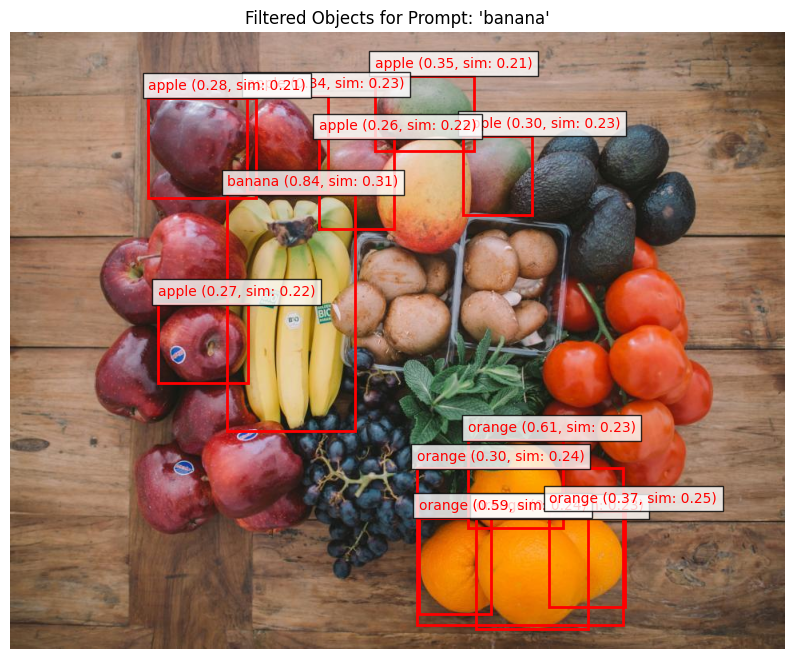

In [ ]:


# Import necessary libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from ultralytics import YOLO
from open_clip import create_model, tokenize
from google.colab import files

# Upload the image
uploaded = files.upload()
image_path = list(uploaded.keys())[0]

# Load the image
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.title("Uploaded Image")
plt.show()

# User prompt
text_prompt = input("Enter the text prompt to identify objects: ")

# Load YOLOv11 model (pre-trained on COCO dataset)
model = YOLO("yolo11n.pt")  # YOLOv11 model
results = model(image_path)  # Perform inference

# Extract detection results from the tensor
detections = results[0].boxes.data.cpu().numpy()  # Extract bounding box data as NumPy array
boxes = detections[:, :4]  # Bounding box coordinates
scores = detections[:, 4]  # Confidence scores
classes = detections[:, 5].astype(int)  # Class indices

# Access class names from the YOLOv11 model
class_names = model.names  # Mapping class indices to names

# Ensure that boxes exist
if len(boxes) == 0:
    raise ValueError("No objects detected in the image!")

# Load CLIP model
clip_model = create_model("ViT-B-32", pretrained="openai")
clip_model.eval()
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)

# Updated Preprocessing Function
def preprocess_pil_image(image, device):
    """
    Preprocess a PIL image for CLIP input.
    Resizes the image to 224x224, converts to tensor, normalizes, and reshapes it.
    """
    image = image.resize((224, 224))  # Resize image to 224x224
    image_array = np.array(image)  # Convert PIL image to NumPy array
    image_tensor = torch.tensor(image_array).permute(2, 0, 1).unsqueeze(0).float().to(device)  # HWC -> CHW
    image_tensor = image_tensor / 255.0  # Normalize to [0, 1]
    return image_tensor

# Filter detections with CLIP and print debug information
filtered_boxes = []
print("Debug Information for All Detected Objects:")
for i, box in enumerate(boxes):
    # Crop object from the image
    xmin, ymin, xmax, ymax = map(int, box)  # Ensure indices are integers
    cropped_object = image.crop((xmin, ymin, xmax, ymax))

    # Preprocess the cropped object and text
    image_input = preprocess_pil_image(cropped_object, device)
    text_input = tokenize([text_prompt]).to(device)

    # Compute similarity using CLIP
    with torch.no_grad():
        image_features = clip_model.encode_image(image_input)
        text_features = clip_model.encode_text(text_input)
        similarity = torch.cosine_similarity(image_features, text_features).item()

    # Print debug information for each detected object
    print(f"Detected Object: {class_names[classes[i]]}")
    print(f"  YOLO Confidence: {scores[i]:.2f}")
    print(f"  CLIP Similarity with Prompt ('{text_prompt}'): {similarity:.2f}")

    # Threshold similarity to include the object
    if similarity > 0.2:  # Adjust threshold as needed
        filtered_boxes.append((box, class_names[classes[i]], scores[i], similarity))

# Visualize results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(image)
ax.axis("off")
for box, label, score, similarity in filtered_boxes:
    xmin, ymin, xmax, ymax = box
    ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color="red", linewidth=2))
    ax.text(
        xmin, ymin - 10, f"{label} ({score:.2f}, sim: {similarity:.2f})",
        color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.8)
    )
plt.title(f"Filtered Objects for Prompt: '{text_prompt}'")
plt.show()